In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile

from silx.image.projection import Projection
from ppfft.inverse.fast_direct_inverse import precompute_all, fast_direct_inversion
from ppfft.reconstruction.polar_to_pp import new_polar_to_pseudopolar
from ppfft.tools.pad import pad

In [2]:
def create_shepp_logan(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]

In [3]:
n = 1000
im = create_shepp_logan(n)

m = 2 * n + 1
theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time
proj = Projection(im.shape, angles=theta)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

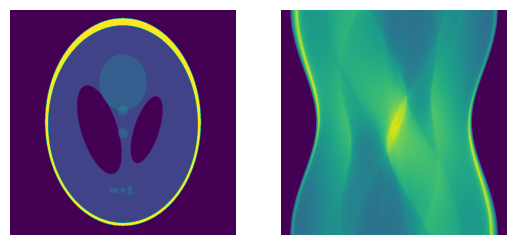

In [4]:
fig, axes=  plt.subplots(1, 2)

axes[0].imshow(im)
axes[1].imshow(sinogram)

[ax.set_axis_off() for ax in axes]
plt.show()

In [5]:
precomputations = precompute_all(n)

# Interpolation polar $\longrightarrow$ pseudo-polar

In [13]:
transpose_sino = fft_sinogram.T

In [14]:
hori_ppfft, vert_ppfft = new_polar_to_pseudopolar(transpose_sino)

In [27]:
%timeit new_polar_to_pseudopolar(transpose_sino)

2.53 s ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
cProfile.run("new_polar_to_pseudopolar(transpose_sino)", 'profiling/profile_interpolation.prof')

# Fast direct inversion

In [ ]:
sol = fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)

In [16]:
cProfile.run("fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)", 'profiling/profile_direct_inversion.prof') 

# Conclusion

In the interpolation from polar to pseudo-polar, 66% of the computation time is the initialization (``__init__``) of scipy's interpolators, and 20% is spent in ``polyint`` which might be the evaluation of the interpolator.

In ``fast_direct_inversion``, 85% of the computation time is ``scipy.linalg.matmul_toeplitz``.

Therefore, around 85% of the computation time is from ``scipy``, which means it is difficult to optimize the code right now.